# Testing Markov and semi-Markov generation

In [1]:
import numpy as np
import seaborn as sns

from types import SimpleNamespace

from bioslds.markov import SemiMarkov
from bioslds.plotting import FigureManager

### Some useful definitions

In [2]:
def normalize_prob(v: np.ndarray):
    return v / np.sum(v)

## Pure Markov

Here we do not put any constraints on dwell time.

### Test statistics of initial state

In [3]:
rng = np.random.default_rng(4)
pure_ini = SimpleNamespace(n_components=5, n_samples=1000)
pure_ini.start_prob = normalize_prob(rng.uniform(size=pure_ini.n_components))
pure_ini.smm = SemiMarkov(pure_ini.n_components, start_prob=pure_ini.start_prob)

pure_ini.ini_states = np.zeros(pure_ini.n_samples, dtype=int)
for i in range(pure_ini.n_samples):
    crt_seq = pure_ini.smm.sample(1)
    pure_ini.ini_states[i] = crt_seq[0]

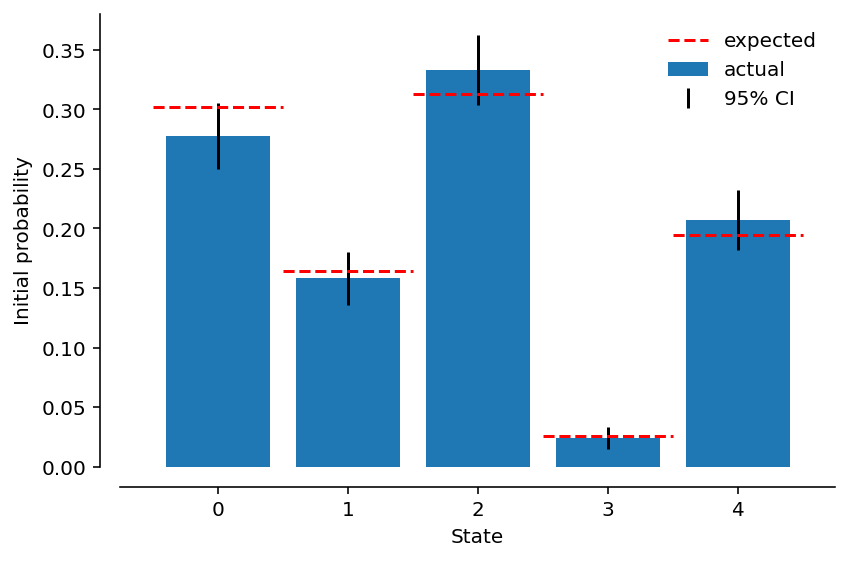

In [4]:
with FigureManager() as (_, ax):
    crt_heights, _, _ = ax.hist(
        pure_ini.ini_states,
        bins=np.arange(pure_ini.n_components + 1),
        rwidth=0.8,
        align="left",
        density=True,
        label="actual",
    )
    crt_error_estimates = np.sqrt(crt_heights * (1 - crt_heights) / pure_ini.n_samples)
    ax.errorbar(
        np.arange(pure_ini.n_components),
        crt_heights,
        1.96 * crt_error_estimates,
        label="95% CI",
        ls="none",
        c="k",
    )

    ax.plot(
        (np.arange(pure_ini.n_components)[:, None] + [-0.5, 0.5, np.nan]).ravel(),
        np.repeat(pure_ini.start_prob, 3),
        c="r",
        ls="--",
        label="expected",
    )
    ax.legend(frameon=False)

    ax.set_xticks(np.arange(pure_ini.n_components))
    ax.set_xlabel("State")
    ax.set_ylabel("Initial probability")

### Test transition statistics

In [5]:
rng = np.random.default_rng(5)
pure_trans = SimpleNamespace(n_components=4, n_samples=20000)
pure_trans.trans_mat = np.asarray(
    [
        normalize_prob(rng.uniform(size=pure_trans.n_components))
        for _ in range(pure_trans.n_components)
    ]
)
pure_trans.smm = SemiMarkov(pure_trans.n_components, trans_mat=pure_trans.trans_mat)

crt_seq = pure_trans.smm.sample(pure_trans.n_samples + 1)
# encoding transitions as n_components * start_state + end_state
pure_trans.transitions = np.zeros(len(crt_seq), dtype=int)
for i in range(1, len(crt_seq)):
    crt_s1 = crt_seq[i - 1]
    crt_s2 = crt_seq[i]
    pure_trans.transitions[i] = crt_s1 * pure_trans.n_components + crt_s2
    
pure_trans.trans_mat_flat = pure_trans.trans_mat.ravel()

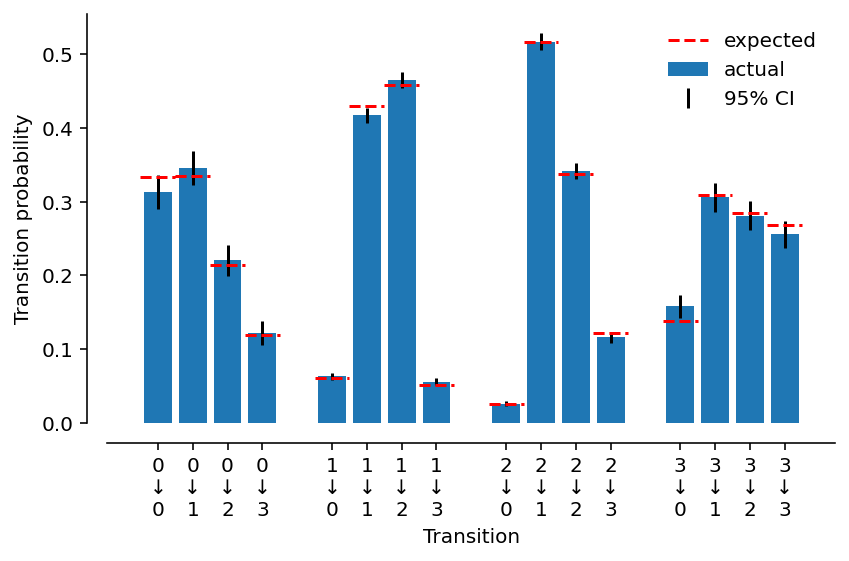

In [6]:
with FigureManager() as (_, ax):
    crt_x = np.hstack(
        [
            i * (pure_trans.n_components + 1) + np.arange(pure_trans.n_components)
            for i in range(pure_trans.n_components)
        ]
    )
    crt_heights = []
    crt_error_estimates = []
    for i in range(pure_trans.n_components):
        crt_low = i * pure_trans.n_components
        crt_high = crt_low + pure_trans.n_components
        crt_transitions = (
            pure_trans.transitions[
                (pure_trans.transitions >= crt_low)
                & (pure_trans.transitions < crt_high)
            ]
            - crt_low
        )
        crt_heights_each, _ = np.histogram(
            crt_transitions, bins=np.arange(pure_trans.n_components + 1), density=True,
        )
        crt_error_estimates_each = np.sqrt(
            crt_heights_each * (1 - crt_heights_each) / len(crt_transitions)
        )

        crt_heights.extend(crt_heights_each)
        crt_error_estimates.extend(crt_error_estimates_each)

    crt_heights = np.asarray(crt_heights)
    crt_error_estimates = np.asarray(crt_error_estimates)

    ax.bar(crt_x, crt_heights, label="actual")
    ax.errorbar(
        crt_x,
        crt_heights,
        1.96 * crt_error_estimates,
        label="95% CI",
        ls="none",
        c="k",
    )

    ax.plot(
        (crt_x[:, None] + [-0.5, 0.5, np.nan]).ravel(),
        np.repeat(pure_trans.trans_mat_flat, 3),
        c="r",
        ls="--",
        label="expected",
    )
    ax.legend(frameon=False)

    ax.set_xticks(crt_x)
    ax.set_xticklabels(
        [
            "{}\n↓\n{}".format(i // pure_trans.n_components, i % pure_trans.n_components)
            for i in range(pure_trans.n_components ** 2)
        ]
    )
    ax.set_xlabel("Transition")
    ax.set_ylabel("Transition probability")

### Test dwell time distribution

In [7]:
def to_rle(seq: np.ndarray) -> list:
    starts = np.hstack(([0], np.diff(seq).nonzero()[0] + 1, len(seq)))
    rle = [(seq[tmp1], tmp2 - tmp1) for tmp1, tmp2 in zip(starts, starts[1:])]

    return rle

In [8]:
rng = np.random.default_rng(7)
pure_dwell = SimpleNamespace(n_components=3, n_samples=10000)
pure_dwell.trans_mat = np.asarray(
    [
        normalize_prob(rng.uniform(size=pure_dwell.n_components))
        for _ in range(pure_dwell.n_components)
    ]
)
pure_dwell.smm = SemiMarkov(pure_dwell.n_components, trans_mat=pure_dwell.trans_mat)

pure_dwell.seq = pure_dwell.smm.sample(pure_dwell.n_samples + 1)
pure_dwell.seq_rle = to_rle(pure_dwell.seq)

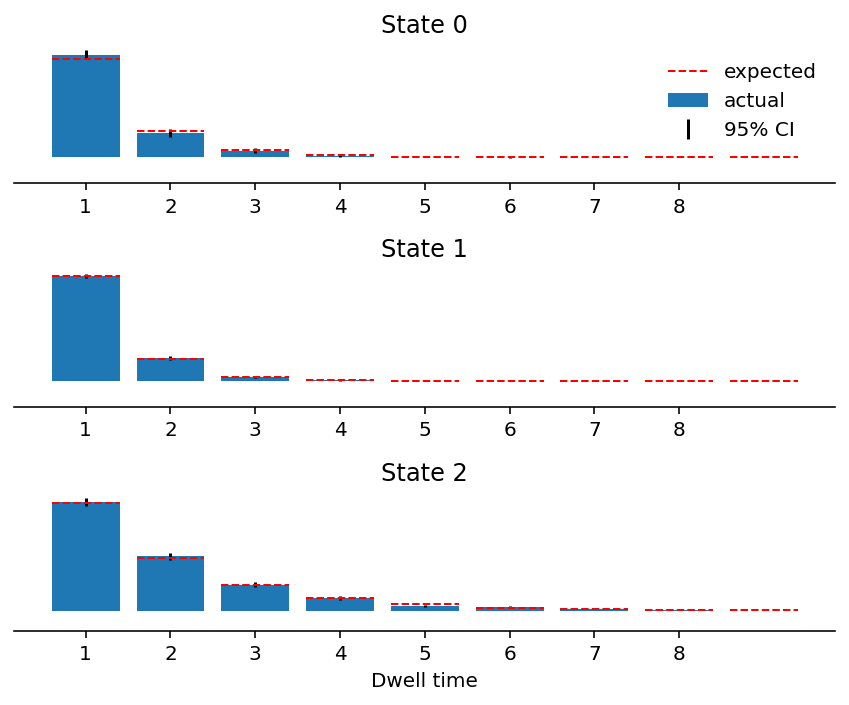

In [9]:
with FigureManager(
    pure_dwell.n_components, 1, figsize=(6, 5), despine_kws={"left": True}
) as (_, axs):
    crt_max_dwell = 9
    for i, ax in enumerate(axs):
        crt_dwell_times = [_[1] for _ in pure_dwell.seq_rle if _[0] == i]
        crt_heights, _, _ = ax.hist(
            crt_dwell_times,
            bins=np.arange(1, crt_max_dwell + 1),
            rwidth=0.8,
            align="left",
            label="actual",
            density=True,
        )
        crt_error_estimates = np.sqrt(
            crt_heights * (1 - crt_heights) / len(crt_dwell_times)
        )
        ax.errorbar(
            np.arange(1, crt_max_dwell),
            crt_heights,
            1.96 * crt_error_estimates,
            label="95% CI",
            ls="none",
            c="k",
        )

        crt_stay_p = pure_dwell.trans_mat[i, i]
        crt_expected = crt_stay_p ** np.arange(crt_max_dwell) * (1 - crt_stay_p)
        ax.plot(
            (np.arange(1, crt_max_dwell + 1)[:, None] + [-0.4, 0.4, np.nan]).ravel(),
            np.repeat(crt_expected, 3),
            c="r",
            ls="--",
            lw=1.0,
            label="expected",
        )

        ax.set_title(f"State {i}")
        ax.set_xticks(np.arange(1, crt_max_dwell))
        ax.set_yticks([])

    axs[0].legend(frameon=False)
    axs[-1].set_xlabel("Dwell time")